In [118]:
import pandas as pd
import numpy as np

In [119]:
import os

In [120]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [121]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv" , low_memory=True, usecols=["user_id","anime_id","rating"])

In [122]:
n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings >= 400].index)].copy() ## Filtering experienced user from inexperienced user

In [123]:
from sklearn.preprocessing import MinMaxScaler

In [124]:
scaler = MinMaxScaler()
rating_df["rating"] = scaler.fit_transform(rating_df[["rating"]])

In [125]:
min(rating_df["rating"])

0.0

In [126]:
max(rating_df["rating"])

1.0

In [127]:
np.mean(rating_df["rating"])

np.float64(0.4073779191986666)

In [128]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x : i for i , x in enumerate(user_ids)}
user2user_decoded = {i : x for i , x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [129]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x : i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i , x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [130]:
# Introducing randomness in the dataframe
rating_df = rating_df.sample(frac=1,random_state=43).reset_index(drop=True)

In [131]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
user        0
anime       0
dtype: int64

In [132]:
X = rating_df[["user","anime"]].values
y = rating_df["rating"]

In [133]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train , y_test = train_test_split(X,y, test_size=1000, random_state=43)

In [134]:
X_train_array = [X_train[: , 0], X_train[:,1]]
X_test_array = [X_test[: , 0], X_test[:,1]]

In [135]:

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping

from wordcloud import WordCloud


In [136]:
n_users = len(user2user_encoded)

In [137]:
n_anime = len(anime2anime_encoded)

In [138]:
def RecommenderNet():
    embedding_size = 128
    user = Input(name="user",shape=[1])

    user_embedding = Embedding(name="user_embedding", input_dim=n_users,output_dim=embedding_size)(user)
    
    anime = Input(name="anime",shape=[1])

    anime_embedding = Embedding(name="anime_embedding",input_dim=n_anime,output_dim=embedding_size)(anime)

    x = Dot(name="dot_product" ,normalize=True , axes=2)([user_embedding,anime_embedding])

    x = Flatten()(x)

    x = Dense(1,kernel_initializer='he_normal')(x)

    x = BatchNormalization()(x)

    x = Activation("sigmoid")(x) 

    model = Model(inputs=[user,anime], outputs=x)

    model.compile(loss="binary_crossentropy",metrics=["mae","mse"],optimizer='Adam')
    return model

In [139]:
model = RecommenderNet()

In [140]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │  1,068,544 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,246,912 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,315,462 (12.65 MB)

 Trainable params: 3,315,460 (12.65 MB)

 Non-trainable params: 2 (8.00 B)

In [141]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [142]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch), verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True,monitor="val_loss",mode="min",save_best_only=True)

early_stopping = EarlyStopping(patience=3,monitor="val_loss",mode="min",restore_best_weights=True)


In [143]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [144]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data = (X_test_array,y_test),
    callbacks=my_callbacks
)

Epoch 1/20
653/653 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - loss: 0.6959 - mae: 0.3628 - mse: 0.1577 - val_loss: 0.6929 - val_mae: 0.3701 - val_mse: 0.1603 - learning_rate: 1.0000e-05
Epoch 2/20
653/653 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 0.6939 - mae: 0.3624 - mse: 0.1567 - val_loss: 0.6921 - val_mae: 0.3701 - val_mse: 0.1599 - learning_rate: 1.8000e-05
Epoch 3/20
653/653 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 0.6914 - mae: 0.3620 - mse: 0.1555 - val_loss: 0.6903 - val_mae: 0.3700 - val_mse: 0.1590 - learning_rate: 2.6000e-05
Epoch 4/20
653/653 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 0.6890 - mae: 0.3616 - mse: 0.1543 - val_loss: 0.6887 - val_mae: 0.3699 - val_mse: 0.1582 - learning_rate: 3.4000e-05
Epoch 5/20
653/653 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - loss: 0.6863 - mae: 0.3612 - mse: 0.1529 - val_loss: 0.6863 - val_mae: 0.3693 - val_mse: 0.1570 - learning_rate: 4.2000e-05
Epoch 6/20
653/653 ━━━━━━━━━━━━━━━━━━━━ 25s 37ms/step - loss: 0.6771 - mae: 0.3558 - mse: 0.1484 - v

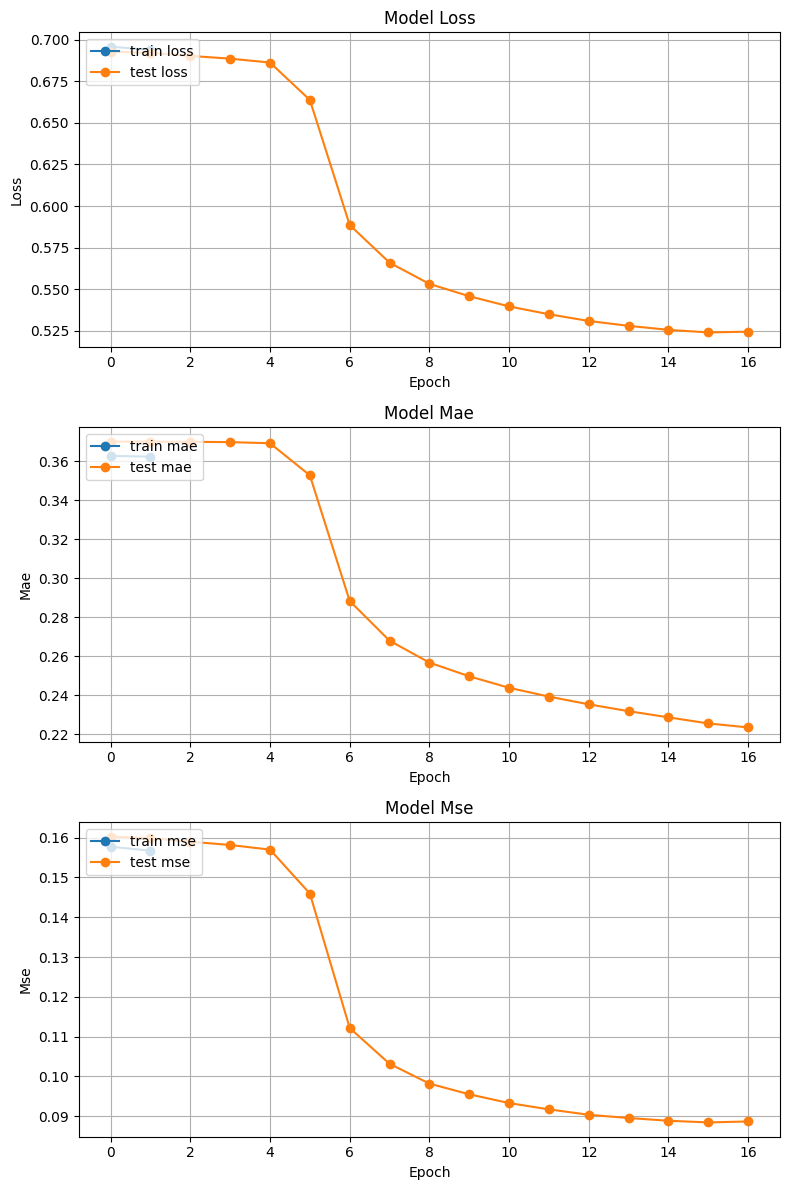

In [145]:
import matplotlib.pyplot as plt
metrics = ["loss","mae","mse"]

#Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) *4 ))

for i,metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:2],marker="o",label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [146]:
def extract_weights(name,model):
    weight_layer= model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [147]:
anime_weights = extract_weights("anime_embedding",model)

In [148]:
user_weights = extract_weights("user_embedding",model)

In [149]:
df = pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, Magic",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [150]:
df = df.replace("Unknown",np.nan)

In [151]:
df.isnull().sum()

MAL_ID               0
Name                 0
Score             5141
Genres              63
English name     10565
Japanese name       48
Type                37
Episodes           516
Aired              309
Premiered        12817
Producers         7794
Licensors        13616
Studios           7079
Source            3567
Duration           555
Rating             688
Ranked            1762
Popularity           0
Members              0
Favorites            0
Watching             0
Completed            0
On-Hold              0
Dropped              0
Plan to Watch        0
Score-10           437
Score-9           3167
Score-8           1371
Score-7            503
Score-6            511
Score-5            584
Score-4            977
Score-3           1307
Score-2           1597
Score-1            459
dtype: int64

In [152]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]

In [153]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    
    except:
        print("Error")
    return name

In [154]:
df["eng_version"] = df.anime_id.apply( lambda x:getAnimeName(x))

In [155]:
df["eng_version"].isna().sum()

np.int64(0)

In [156]:
df.sort_values(by='Score', inplace=True, ascending=False,kind="quicksort", na_position="last")

In [157]:
df = df[["anime_id","eng_version",'Score','Genres','Episodes','Type','Premiered','Studios','Source']]

In [158]:
df.isnull().sum()

anime_id           0
eng_version        0
Score           5141
Genres            63
Episodes         516
Type              37
Premiered      12817
Studios         7079
Source          3567
dtype: int64

In [159]:
pd.set_option('display.max_rows', None)

In [160]:
df[df['Genres'].isnull()][['anime_id', 'eng_version', 'Genres']]

,anime_id,eng_version,Genres
10145,29765,Metropolis (2009),NaN
10687,30862,Woman Who Stole Fingers,NaN
11471,32695,The Little Match Girl,NaN
11874,33390,Zunda Horizon,NaN
10235,29923,Fukusuke,NaN
10233,29921,Bunbuku Chagama (1958),NaN
12743,34993,The Lazy Fox,NaN
11763,33187,Katsudou Shashin,NaN
11136,31834,Mormorando,NaN
9839,28655,PiKA PiKA,NaN


In [161]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]

In [162]:
getAnimeFrame(40028,df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Studios,Source
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,MAPPA,Manga


In [163]:
getAnimeFrame("Gintama Season 4",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Studios,Source
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",51,TV,Spring 2015,Bandai Namco Pictures,Manga


In [164]:

syn_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",low_memory=True)

In [165]:
syn_df.drop(columns=['Score'], inplace=True)

In [166]:
replace = df.copy()

In [167]:
replace.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Studios,Source
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,Bones,Manga
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,MAPPA,Manga
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,White Fox,Visual novel
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",10,TV,Spring 2019,Wit Studio,Manga
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",51,TV,Spring 2015,Bandai Namco Pictures,Manga


In [168]:
syn_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease spreading through the smoke from the blast, a whopping three hundred million woolong price is placed on the head of the supposed perpetrator. With lives at stake and a solution to their money problems in sight, the Bebop crew springs into action. Spike, Jet, Faye, and Edward, followed closely by Ein, split up to pursue different leads across Alba City. Through their individual investigations, they discover a cover-up scheme involving a pharmaceutical company, revealing a plot that reaches much further than the ragtag team of bounty hunters could have realized."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,000,000 bounty on his head. The reason: he's a merciless villain who lays waste to all those that oppose him and flattens entire cities for fun, garnering him the title ""The Humanoid Typhoon."" He leaves a trail of death and destruction wherever he goes, and anyone can count themselves dead if they so much as make eye contact—or so the rumors say. In actuality, Vash is a huge softie who claims to have never taken a life and avoids violence at all costs. With his crazy doughnut obsession and buffoonish attitude in tow, Vash traverses the wasteland of the planet Gunsmoke, all the while followed by two insurance agents, Meryl Stryfe and Milly Thompson, who attempt to minimize his impact on the public. But soon, their misadventures evolve into life-or-death situations as a group of legendary assassins are summoned to bring about suffering to the trio. Vash's agonizing past will be unraveled and his morality and principles pushed to the breaking point."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, Magic","ches are individuals with special powers like ESP, telekinesis, mind control, etc. Robin, a 15-year-old craft user, arrives from Italy to Japan to work for an organization named STN Japan Division (STN-J) as a replacement for one of STN-J's witch hunters who was recently killed. Unlike other divisions of STN, STN-J tries to capture the witches alive in order to learn why and how they became witches in the first place. (Source: ANN)"
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural","It is the dark century and the people are suffering under the rule of the devil, Vandel, who is able to manipulate monsters. The Vandel Busters are a group of people who hunt these devils, and among them, the Zenon Squad is known to be the stronge

In [169]:
syn_df.columns

Index(['MAL_ID', 'Name', 'Genres', 'sypnopsis'], dtype='object')

In [170]:
# Merge syn_df with the 'anime_id' and 'eng_version' columns from df
syn_df = syn_df.merge(df[['anime_id', 'eng_version']], left_on='MAL_ID', right_on='anime_id', how='left')

# If you want, you can drop the redundant 'anime_id' column
syn_df.drop(columns=['anime_id'], inplace=True)

In [171]:
def getSynopsis(anime,df):
    if isinstance(anime,int):
        return syn_df[syn_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return syn_df[syn_df.eng_version == anime].sypnopsis.values[0]

In [172]:
getSynopsis("Gintama Season 4",df)

"Gintoki, Shinpachi, and Kagura return as the fun-loving but broke members of the Yorozuya team! Living in an alternate-reality Edo, where swords are prohibited and alien overlords have conquered Japan, they try to thrive on doing whatever work they can get their hands on. However, Shinpachi and Kagura still haven't been paid... Does Gin-chan really spend all that cash playing pachinko? Meanwhile, when Gintoki drunkenly staggers home one night, an alien spaceship crashes nearby. A fatally injured crew member emerges from the ship and gives Gintoki a strange, clock-shaped device, warning him that it is incredibly powerful and must be safeguarded. Mistaking it for his alarm clock, Gintoki proceeds to smash the device the next morning and suddenly discovers that the world outside his apartment has come to a standstill. With Kagura and Shinpachi at his side, he sets off to get the device fixed; though, as usual, nothing is ever that simple for the Yorozuya team. Filled with tongue-in-cheek

In [173]:
def getSynopsis1(anime):
    if isinstance(anime, int):
        result = syn_df[syn_df.MAL_ID == anime]
        if not result.empty:
            return result.sypnopsis.values[0]
    elif isinstance(anime, str):
        result = syn_df[syn_df.eng_version == anime]
        if not result.empty:
            return result.sypnopsis.values[0]
    return None

In [174]:
getSynopsis(2,df)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [175]:
getSynopsis1(1)

'In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as "Cowboys." The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member\'s dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic an

In [204]:
getSynopsis1(34755)

nan

In [176]:
syn_df[syn_df.isnull().any(axis=1)]

,MAL_ID,Name,Genres,sypnopsis,eng_version
11451,34755,Kuma no Gakkou: Patissier Jackie to Ohisama no Sweets,"Comedy, Kids",NaN,Kuma no Gakkou: Patissier Jackie to Ohisama no Sweets
11469,34794,Yukai na Animal Bus,"Comedy, Kids",NaN,Funny Animal Bus
13686,38475,Yuru Camp△ Movie,"Comedy, Slice of Life",NaN,Yuru Camp△ Movie
15025,40714,Youkai Watch Jam: Youkai Gakuen Y - N to no Souguu,"Comedy, Demons, Kids, Supernatural, School",NaN,Youkai Watch Jam: Youkai Gakuen Y - N to no Souguu
15747,42717,Kaeru no Pickles: Kimochi no Iro,"Slice of Life, Kids",NaN,Kaeru no Pickles: Kimochi no Iro
16056,44848,Iii Icecrin,Kids,NaN,Iii Icecrin
16110,45731,Argonavis from BanG Dream! Movie,Music,NaN,Argonavis from BanG Dream! Movie
16120,46095,Vivy: Fluorite Eye's Song,Sci-Fi,NaN,Vivy: Fluorite Eye's Song


In [177]:
syn_df.isnull().sum()

MAL_ID         0
Name           0
Genres         0
sypnopsis      8
eng_version    0
dtype: int64

In [178]:
pd.set_option("max_colwidth",None)

In [179]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Studios,Source
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,Bones,Manga
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,MAPPA,Manga
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,White Fox,Visual novel
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",10,TV,Spring 2019,Wit Studio,Manga
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",51,TV,Spring 2015,Bandai Namco Pictures,Manga


In [180]:
def find_similiar_animes(name,anime_weights,anime2anime_encoded,
                         anime2anime_decoded,df,n=10,return_dist=False,neg=False):
    
    try:
        index = getAnimeFrame(name,df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        weights = anime_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:][::-1]
        

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            decoded_id = anime2anime_decoded.get(close)

            

            anime_frame = getAnimeFrame(decoded_id,df)
            synopsis = getSynopsis1(decoded_id)
            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]

            SimilarityArr.append({
                "anime_id" : decoded_id,
                "name" : anime_name,
                "similarity" : similarity,
                "genre" : genre,
                "synopsis" : synopsis
                
            })

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        return Frame[Frame.anime_id != index].drop(["anime_id"],axis=1)
    
    except Exception as e:
        print("Error occured",e)
    

In [188]:
find_similiar_animes("Fullmetal Alchemist:Brotherhood",anime_weights,anime2anime_encoded,anime2anime_decoded,
                     df)

,name,similarity,genre,synopsis
1,Death Note,0.861466,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen","shinigami, as a god of death, can kill any person—provided they see their victim's face and write their victim's name in a notebook called a Death Note. One day, Ryuk, bored by the shinigami lifestyle and interested in seeing how a human would use a Death Note, drops one into the human realm. High school student and prodigy Light Yagami stumbles upon the Death Note and—since he deplores the state of the world—tests the deadly notebook by writing a criminal's name in it. When the criminal dies immediately following his experiment with the Death Note, Light is greatly surprised and quickly recognizes how devastating the power that has fallen into his hands could be. With this divine capability, Light decides to extinguish all criminals in order to build a new world where crime does not exist and people worship him as a god. Police, however, quickly discover that a serial killer is targeting criminals and, consequently, try to apprehend the culprit. To do this, the Japanese investigators count on the assistance of the best detective in the world: a young and eccentric man known only by the name of L."
2,Attack on Titan,0.834079,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations. After witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Kyojin follows Eren, along with his adopted sister Mikasa Ackerman and his childhood friend Armin Arlert, as they join the brutal war against the titans and race to discover a way of defeating them before the last walls are breached."
3,Code Geass:Lelouch of the Rebellion,0.829400,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School","In the year 2010, the Holy Empire of Britannia is establishing itself as a dominant military nation, starting with the conquest of Japan. Renamed to Area 11 after its swift defeat, Japan has seen significant resistance against these tyrants in an attempt to regain independence. Lelouch Lamperouge, a Britannian student, unfortunately finds himself caught in a crossfire between the Britannian and the Area 11 rebel armed forces. He is able to escape, however, thanks to the timely appearance of a mysterious girl named C.C., who bestows upon him Geass, the ""Power of Kings."" Realizing the vast potential of his newfound ""power of absolute obedience,"" Lelouch embarks upon a perilous journey as the masked vigilante known as Zero, leading a merciless onslaught against Britannia in order to get revenge once and for all."
4,Code Geass:Lelouch of the Rebellion R2,0.825649,"Action, Military, Sci-Fi, Super Power, Drama, Mecha","One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the Elevens by Britannia, which has increased significantly in order to crush any hope of

In [189]:
def find_similiar_user(item_input, user_weights,user2user_encoded,
                       user2user_decoded,n=10,return_dist=False,neg=False):
    try:
        index = int(item_input)
        encoded_index = user2user_encoded.get(index)
        weights = user_weights

        if encoded_index is not None:

            dists = np.dot(weights,weights[encoded_index])
            sorted_dists = np.argsort(dists)

            n=n+1
            
            if neg:
                closest = sorted_dists[:n]
            else:
                closest = sorted_dists[-n:][::-1]
            

            if return_dist:
                return dists,closest
            
            SimiliarityArr = []

            for close in closest:
                similarity = dists[close]

            
                decoded_id = user2user_decoded.get(close)
                SimiliarityArr.append({
                    "similiar_users" : decoded_id,
                    "similarity" : similarity,
                    
                })
                
                sim_users = pd.DataFrame(SimiliarityArr).sort_values(by="similarity",ascending=False) 
                sim_users = sim_users[sim_users.similiar_users != item_input]
            return sim_users
        else:
            print(f"Cannot find similiar users for {item_input}! ")
    except Exception as e:
        print("Error occured",e)
         

In [190]:
find_similiar_user(11880,user_weights,user2user_encoded,user2user_decoded)

,similiar_users,similarity
1,5586,0.443828
2,14638,0.436612
3,19928,0.435786
4,22526,0.432681
5,26154,0.432019
6,22188,0.425033
7,7098,0.424696
8,24687,0.423357
9,32589,0.422172
10,5936,0.421218


In [192]:
find_similiar_user(1,user_weights,user2user_encoded,user2user_decoded)

Cannot find similiar users for 1! 


In [193]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [194]:
from collections import defaultdict

In [195]:
def getFavGenre(frame,plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list =[]
    for genres in frame['Genres']:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1
    
    if plot:
        showWordCloud(all_genres)
    
    return genres_list

In [196]:
cb = getAnimeFrame(1,df)

In [197]:
cb

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Studios,Source
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26,TV,Spring 1998,Sunrise,Original


In [198]:
getFavGenre(cb)

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

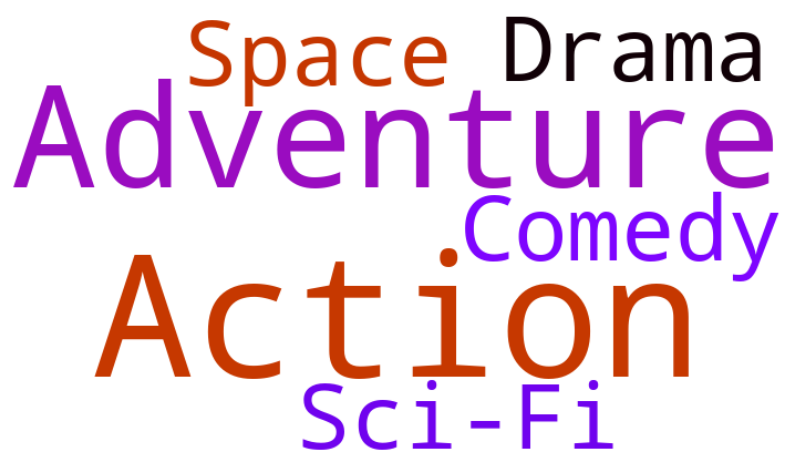

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [199]:
getFavGenre(cb , plot=True)

In [200]:
def get_user_preferences(user_id, rating_df,df, verbose=0, plot=False ):
    
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    if not animes_watched_by_user.rating.empty:
        user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)
    else:
        user_rating_percentile = np.nan


    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating",ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if not anime_df_rows.empty :
      if plot:
          getFavGenre(anime_df_rows, plot=True)
    

    return anime_df_rows


In [201]:
get_user_preferences(0,rating_df,df)

,eng_version,Genres


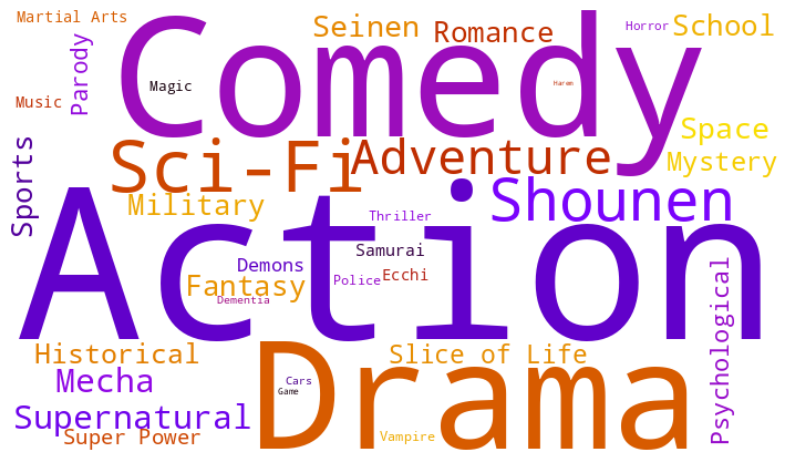

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
7261,Gintama:Enchousen,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
12242,Gintama Season 5,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
7249,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
833,Gintama,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
7577,Monogatari Series:Second Season,"Mystery, Comedy, Supernatural, Romance, Vampire"


In [202]:
get_user_preferences(11880,rating_df,df,plot=True)

In [214]:
def get_user_recommendations(similar_users,user_pref,df,rating_df,syn_df,n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similiar_users.values:
        pref_list = get_user_preferences(user_id,rating_df,df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
        anime_list = pd.DataFrame(anime_list)

        sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

        for i,anime_name in enumerate(sorted_list.index):
            n_users_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

            if isinstance(anime_name,str):
                frame = getAnimeFrame(anime_name,df)
                genre = frame.Genres.values[0]
                synopsis = getSynopsis1(anime_name)

                recommended_animes.append({
                    "n" : n_users_pref,
                    "anime_name" : anime_name,
                    "Genres": genre,
                    "synopsis" : synopsis
                })
    return pd.DataFrame(recommended_animes).head(n)
               

    

In [215]:
sim_users = find_similiar_user(24730,user_weights,user2user_encoded,user2user_decoded)

In [216]:
use_pre = get_user_preferences(24730,rating_df,df)

In [218]:
get_user_recommendations(similar_users=sim_users,user_pref=use_pre,df=df,rating_df=rating_df,syn_df=syn_df)

,n,anime_name,Genres,synopsis
0,17,Bakuman.,"Comedy, Drama, Romance, Shounen","s a child, Moritaka Mashiro dreamt of becoming a mangaka, just like his childhood hero and uncle, Tarou Kawaguchi, creator of a popular gag manga. But when tragedy strikes, he gives up on his dream and spends his middle school days studying, aiming to become a salaryman instead. One day, his classmate Akito Takagi, the school's top student and aspiring writer, notices the detailed drawings in Moritaka's notebook. Seeing the vast potential of his artistic talent, Akito approaches Moritaka, proposing that they become mangaka together. After much convincing, Moritaka realizes that if he is able to create a popular manga series, he may be able to get the girl he has a crush on, Miho Azuki, to take part in the anime adaptation as a voice actor. Thus the pair begins creating manga under the pen name Muto Ashirogi, hoping to become the greatest mangaka in Japan, the likes of which no one has ever seen."
1,9,Baccano!,"Action, Comedy, Historical, Mystery, Supernatural","During the early 1930s in Chicago, the transcontinental train, Flying Pussyfoot, is starting its legendary journey that will leave a trail of blood all over the country. At the same time in New York, the ambitious scientist Szilard and his unwilling aide Ennis are looking for missing bottles of the immortality elixir. In addition, a war between the mafia groups is getting worse. On board the Advena Avis, in 1711, alchemists are about to learn the price of immortality. Based on the award-winning light novels of the same name, Baccano! follows several events that initially seem unrelated, both in time and place, but are part of a much bigger story—one of alchemy, survival, and immortality. Merging these events together are the kindhearted would-be thieves, Isaac and Miria, connecting various people, all of them with their own hidden ambitions and agendas, and creating lifelong bonds and consequences for everyone involved."
2,9,The Devil is a Part-Timer!,"Comedy, Demons, Supernatural, Romance, Fantasy","Striking fear into the hearts of mortals, the Demon Lord Satan begins to conquer the land of Ente Isla with his vast demon armies. However, while embarking on this brutal quest to take over the continent, his efforts are foiled by the hero Emilia, forcing Satan to make his swift retreat through a dimensional portal only to land in the human world. Along with his loyal general Alsiel, the demon finds himself stranded in modern-day Tokyo and vows to return and complete his subjugation of Ente Isla—that is, if they can find a way back! Powerless in a world without magic, Satan assumes the guise of a human named Sadao Maou and begins working at MgRonald's—a local fast-food restaurant—to make ends meet. He soon realizes that his goal of conquering Ente Isla is just not enough as he grows determined to climb the corporate ladder and become the ruler of Earth, one satisfied customer at a time! Whether it's part-time work, household chores, or simply trying to pay the rent on time, Hataraku Maou-sama! presents a hilarious view of the most mundane aspects of everyday life, all through the eyes of a hapless demon lord."
3,9,Karneval,"Action, Fantasy, Josei, Mystery, Sci-Fi","DVD bundled with the limited edition of the 10th volume of the manga, previewing the upcoming TV anime and including footage that will not be used in the series."
4,9,Soul Eater,"Action, Fantasy, Comedy, Supernatural, Shounen","Death City is home to the famous Death Weapon Meister Academy, a technical academy headed by the Shinigami—Lord Death himself. Its mission: to raise ""Death Scythes"" for the Shinigami to wield against the many evils of their fantastical world. These Death Scythes, however, are not made from physical weapons; rather, they are born from human hybrids who have the ability to transform their bodies into Demon Weapons, and only after they have consumed the souls of 99 evil beings and one witch's soul. Soul Eater Eva

In [219]:
def hybrid_recommendation(user_id,user_weight=0.5, content_weights=0.5):
    
    ## user recommendation
    similar_users = find_similiar_user(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id,rating_df,df)
    user_recommended_animes = get_user_recommendations(similar_users,user_pref,df,rating_df,syn_df)

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    ## content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        
        similar_animes = find_similiar_animes(str(anime),anime_weights,anime2anime_encoded,anime2anime_decoded,df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
        
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weights
    
    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] ,reverse=True )

    return [anime for anime , score in sorted_animes]


In [220]:
hybrid_recommendation(11880)

['Steins;Gate', 'Toradora!', 'Your Name.', 'Fate/Zero', 'Clannad ~After Story~', 'Code Geass:Lelouch of the Rebellion R2', 'Fate/Zero Season 2', 'Puella Magi Madoka Magica the Movie Part 2:Eternal', 'Code Geass:Lelouch of the Rebellion', 'Re:ZERO -Starting Life in Another World-']


['Code Geass:Lelouch of the Rebellion R2',
 'Code Geass:Lelouch of the Rebellion',
 'Steins;Gate',
 'Fullmetal Alchemist:Brotherhood',
 'Angel Beats!',
 'Death Note',
 'Attack on Titan',
 'Fate/Zero Season 2',
 'No Game, No Life',
 'Your Name.',
 'Fate/Zero',
 'Toradora!',
 'One Punch Man',
 'Clannad ~After Story~',
 'Re:ZERO -Starting Life in Another World-',
 'Bakemonogatari',
 'anohana:The Flower We Saw That Day',
 'Clannad',
 'A Silent Voice',
 'My Hero Academia',
 'Fate/stay night [Unlimited Blade Works]',
 'Fate/stay night [Unlimited Blade Works] Season 2',
 'Fate/stay night:Unlimited Blade Works - Prologue',
 'Puella Magi Madoka Magica the Movie Part 2:Eternal',
 'My Hero Academia 2',
 'Your Lie in April',
 'ERASED',
 'Fate/stay night',
 'Clannad:Another World, Tomoyo Chapter',
 'Clannad ~After Story~:Another World, Kyou Chapter',
 'Puella Magi Madoka Magica the Movie Part 1:Beginnings',
 'Puella Magi Madoka Magica the Movie:Rebellion',
 'Joshiraku OVA',
 'Puella Magi Madoka Mag

In [221]:
hybrid_recommendation(24730)

['Bakuman.', 'Baccano!', 'The Devil is a Part-Timer!', 'Karneval', 'Soul Eater', 'Baccano! Specials', "Monthly Girls' Nozaki-kun", 'Nisekoi:False Love', "So, I Can't Play H!", 'Is This a Zombie?']


["Haganai:I don't have many friends",
 'Bakuman.',
 'The Devil is a Part-Timer!',
 'Nisekoi:False Love',
 'Baccano!',
 'Baccano! Specials',
 'Code Geass:Lelouch of the Rebellion',
 'Durarara!!',
 'Fate/Zero Season 2',
 'No Game, No Life',
 'Sword Art Online',
 'The Pet Girl of Sakurasou',
 'Karneval',
 'Soul Eater',
 "Monthly Girls' Nozaki-kun",
 "So, I Can't Play H!",
 'Is This a Zombie?',
 'Chihayafuru 2',
 'Code Geass:Lelouch of the Rebellion R2',
 "Kuroko's Basketball",
 'Log Horizon',
 'Haikyu!! 3rd Season',
 "Kuroko's Basketball 2",
 'Silver Spoon 2nd Season',
 'Gurren Lagann',
 'Samurai Champloo',
 'Darker than Black',
 'Cowboy Bebop',
 'Mushi-Shi',
 'Black Lagoon',
 'Summer Wars',
 'One Punch Man',
 'Attack on Titan',
 'Is It Wrong to Try to Pick Up Girls in a Dungeon?',
 'Overlord',
 "KonoSuba:God's Blessing on This Wonderful World!",
 'Devils and Realist',
 'Hakkenden -Eight Dogs of the East-',
 'Laughing Under the Clouds',
 'Amnesia',
 'No. 6',
 'The Severing Crime Edge',
 '